# 整合了 任意长度字符加解密，图像加解密
## 有时候调用 DMA 会报错：RuntimeError: DMA channel not started
### 注意：HLS IP核中，最大输入缓冲为 345600 bytes/char 

## Import libraries

In [1]:
from pynq import Overlay
# import pynq.lib.dma
Max_buffer_size = 345600

## Download the AES bitstream

In [2]:
AES_En_De_overlay = Overlay("./bitstream/AES_En_De.bit")

In [3]:
AES_En_De = AES_En_De_overlay.AES_En_De_0
dma_ip = AES_En_De_overlay.axi_dma_0

In [4]:
sendstatus = dma_ip.sendchannel.running
recvstatus = dma_ip.recvchannel.running
print("sendstatus", sendstatus,"recvstatus",recvstatus)

sendstatus True recvstatus True


In [5]:
# AES_En_De_overlay.ip_dict

## Create an MMIO instance to Access AES_En_De

In [6]:
from pynq import MMIO
AES_En_D_address = AES_En_De_overlay.ip_dict['AES_En_De_0']['phys_addr']
addr_range = 0x40  # 64
mmio = MMIO(AES_En_D_address, addr_range)

In [7]:
plain_text = "abcdefghijklmnop"
plain_bytes_object = plain_text.encode("ascii")

key_text = "hello_world_aes_"
key_bytes_object = key_text.encode("ascii")

## Xlnk Class
## 通过 Xlnk()申请一块连续的区域，用于 DMA的数据传输

The [Xlnk class](https://pynq.readthedocs.io/en/v2.4/pynq_libraries/xlnk.html) allows us to create arrays which are contiguous in memory. We can create two contiguous arrays to transfer memory in and out of the DMA as streams. The DMA will handle the inputs so that a full 128 bit block of data is processed by the IP every clock cycle. 

In [8]:
from pynq import Xlnk
import numpy as np

# 通过 Xlnk()申请一块连续的区域，用于 DMA的数据传输
xlnk = Xlnk()
in_buffer = xlnk.cma_array(shape=(len(plain_bytes_object),),dtype = np.uint8)  #uint8
out_buffer = xlnk.cma_array(shape=(len(plain_bytes_object),),dtype = np.uint8)

In [9]:
# help(xlnk.cma_array)

### 把数据搬到 Xlnk() 申请的区域中，准备让DMA传输

In [10]:
plain_bytes_object = np.array( bytearray(plain_bytes_object))
np.copyto(in_buffer,plain_bytes_object)

### AXI LITE 传送 key 、控制HLS IP开始工作

In [11]:
mmio.write(32, key_bytes_object )  # key  # 写可以 写一片连续地址，读无法读一片连续地址
mmio.write(16,16 )                # 明文长度，以char为单位 in_char_len[0]
mmio.write(20, 0 ) # 0加密 1解密             in_char_len[1]
#     mmio.write(24,0 ) # 调试信息                in_char_len[2]
# print(mmio.read(20 ))
# print(mmio.read(24 ))

## 正式让DMA 从 申请的区域  in_buffer  把数据传给 PL中的HLS IP核
## 同时把HLS IP 核处理的结果数据传回到申请的区域中  out_buffer

In [12]:
dma_ip.sendchannel.transfer(in_buffer)
dma_ip.recvchannel.transfer(out_buffer)
mmio.write(0x00, 0x01) # 往 AP_START 位写1 控制AES开始

### 等待 DMA 施工完成

In [13]:
dma_ip.sendchannel.wait()
dma_ip.recvchannel.wait()    

In [14]:
bytes_arrray = bytearray(out_buffer)
print( "密文 hex：", bytes_arrray.hex() )

密文 hex： e29599b52ba355dd5ac4ad0052e9fe54


### 32bytes 字符串

In [15]:
## 明文 密钥
plain_text = "abcdefghijklmnopabcdefghijklmnop"
plain_bytes_object = plain_text.encode("ascii")

num_of_plain_bytes = len(plain_bytes_object)
print(num_of_plain_bytes)

##  xlnk()申请连续地址
in_buffer = xlnk.cma_array(shape=(num_of_plain_bytes,),dtype = np.uint8)  #uint8
out_buffer = xlnk.cma_array(shape=(num_of_plain_bytes,),dtype = np.uint8)

## 把待传输数据搬到 申请的地址 in_buffer
plain_bytes_object = np.array( bytearray(plain_bytes_object))
np.copyto(in_buffer,plain_bytes_object)

## 写HLS IP 的key 和 必要的控制命令
mmio.write(32, key_bytes_object )  # key  # 写可以 写一片连续地址，读无法读一片连续地址
mmio.write(16, num_of_plain_bytes )                # 明文长度，以char为单位 in_char_len[0]
mmio.write(20, 0 ) # 0加密 1解密             in_char_len[1]
#     mmio.write(24,0 ) # 调试信息                in_char_len[2] 

## DMA开始传输，PS-PL send .  PL-PS recv
dma_ip.sendchannel.transfer(in_buffer)
dma_ip.recvchannel.transfer(out_buffer)
mmio.write(0x00, 0x01) # 往 AP_START 位写1 控制AES开始

## 等待DMA 传输完成
dma_ip.sendchannel.wait()
dma_ip.recvchannel.wait()    

## 取出处理完的数据
bytes_arrray = bytearray(out_buffer)
print( "密文 hex：", bytes_arrray.hex() )

32
密文 hex： e29599b52ba355dd5ac4ad0052e9fe54e29599b52ba355dd5ac4ad0052e9fe54


## 调用 HLS IP 的较为底层的函数

In [16]:
from pynq import Xlnk
import numpy as np
xlnk = Xlnk()
"""
def call_AES_En_De(input_bytes, num_of_input_bytes, key_bytes_object, en_or_decryption):
较为底层的调用，实际操控 HLS IP核 的函数
    input:
        input_bytes:   长度 16 的 bytes object/bytearray 类型，  待加/解密的数据
        num_of_input_bytes:  输入input_bytes的 byte 数 
        key_bytes_object: 长度 16 的 bytes object 类型，密钥 bytes object 通过MMIO 连续写入，所以必须是bytes object
        en_or_decryption: 整型 0 加密 1 解密，          控制 HLS IP 加密还是 解密
    
    return:
        bytearray: 长度 16 的 bytearray 类型，          HLS IP 加/解密后的结果bytes object
"""
def call_AES_En_De(input_bytes, num_of_input_bytes, key_bytes_object, en_or_decryption):

    ## 通过 Xlnk()申请一块连续的区域，用于 DMA的数据传输    
    in_buffer = xlnk.cma_array(shape=(num_of_input_bytes,),dtype = np.uint8)  #uint8
    out_buffer = xlnk.cma_array(shape=(num_of_input_bytes,),dtype = np.uint8)

    ## 把待传输数据搬到 申请的地址 in_buffer
    input_bytes = np.array( bytearray(input_bytes))
    np.copyto(in_buffer,input_bytes)

    ## 写HLS IP 的key 和 必要的控制命令
    mmio.write(32, key_bytes_object )  # key  # 写可以 写一片连续地址，读无法读一片连续地址
    mmio.write(16, num_of_input_bytes )                # 明文长度，以char为单位 in_char_len[0]
    mmio.write(20, en_or_decryption ) # 0加密 1解密             in_char_len[1]
    #     mmio.write(24,0 ) # 调试信息                in_char_len[2] 

    while( not( mmio.read(0x00) & 0x4) ): # 等待 bit3 AP_READY，表示可以接收数据，也可判断AP_IDLE 为1
        pass                              # 发现无需等待，AP_READY 等不来
    ## DMA开始传输，PS-PL send .  PL-PS recv
    dma_ip.sendchannel.transfer(in_buffer)
    dma_ip.recvchannel.transfer(out_buffer)
    mmio.write(0x00, 0x01) # 往 AP_START 位写1 控制AES开始

    ## 等待DMA 传输完成
    dma_ip.sendchannel.wait()
    dma_ip.recvchannel.wait()    

    ## 取出处理完的数据
    bytes_arrray = bytearray(out_buffer)
#     print( "密文 hex：", bytes_arrray.hex() ) 
    
    return bytes_arrray

## 把 （明文）输入字符 扩展成128bits的整数倍，不足的话，补0
## 密钥 只能是 128bits，不足的话，补0，多的话，在前面需要先判断，过滤掉这种情况

In [17]:
"""
def expand_to_128b(plain_text, encoding):
使用 给定的编码方式/utf-8 编码，把 输入字符串 扩展成128bits的整数倍，不足的话，补0
    input:
        plain_text:   待扩展成 128bits/ 16 bytes 的输入字符串 
        encoding:   字符串，             定义 编码 方式 ascii unicode utf-8等
    
    return:
        plain_text:   长度 16 的 bytearray 类型， 扩展成 128bits后的字符串
"""
def expand_to_128b(plain_text, encoding= "utf-8" ):
   
    if ( isinstance(plain_text, str) ):
        ## 明文扩展 
        plain_text = bytearray(plain_text.encode(encoding)) # 不用 ("ascii")，使用 utf-8 解决中文编码问题 ，   
        
    elif ( isinstance(plain_text, bytes) ):        
        plain_text = bytearray(plain_text)    # 因为 bytes object 是不可修改的，转为 bytearray 来实现 不足 补0 的操作
    
#     print("utf-8编码后，输入字符串 长度：",len(plain_text))
    len_to_add = 16 - len(plain_text)%16   
    
#     print(plain_text)
    while(len_to_add > 0 and len_to_add < 16 ):
        plain_text.append(0)                     # 加 0
        len_to_add = len_to_add - 1    
    
#     print("扩展到128bits后，输入字符串 长度：",len(plain_text))
#     print("扩展到128bits后，utf-8 解码",plain_text.decode('utf-8'))   
    
    return plain_text

# 基于Stream DMA
## 定义函数，实现任意长度密文、明文输入，相应的解密、加密输出
### 任意长度 字符串 加密/解密，不足的话补0

In [18]:
"""
def string_AES_En_De(plain_text, key_text, en_or_decryption, encoding):
任意长度 字符串 加密/解密，，不足的话补0，
使用 给定的编码方式/utf-8 编码，对字符串编码
    input:
        plain_text: 任意长度 待 加/解密，不足的话，补0
        key_text:   任意长度密钥字符串， 不足的话，补0
        en_or_decryption: 整型 0 加密 1 解密，  控制 HLS IP 加密还是 解密
        encoding:   字符串，             定义 编码 方式 ascii unicode utf-8等
    
    return:
        bytearray: 加密 操作后的 bytearray  解密 操作后的 str    
        
"""
def string_AES_En_De(plain_text, key_text, en_or_decryption, encoding= "utf-8" ):

    ## 明文扩展
    #     plain_text = expand_to_128b(plain_text)    

    ## 密钥扩展
    if( len(key_text.encode( encoding ))<=16 ):      #  'utf-8'
        key_text = expand_to_128b(key_text, encoding)
    else:
        print("key length is too long, 密钥过长, "+encoding+"编码后：",len(key_text.encode( encoding ))) #  'utf-8'
        return b"this is a wrong return~~no!!!"

    result_text = bytearray()
    
    
    if ( en_or_decryption == 0):
        ## 明文扩展     
        plain_text = expand_to_128b(plain_text, encoding)       
        
        len_of_plain_text = len(plain_text)
        
        if( len_of_plain_text < Max_buffer_size):
#             pass # 直接完成
            result_text = call_AES_En_De(plain_text, len_of_plain_text, bytes(key_text), en_or_decryption)
        else:
            i = 0        
            while(i < len_of_plain_text ):
                rest_of_bytes = len_of_plain_text - i
                if(rest_of_bytes > Max_buffer_size ):
                    result_text.extend( call_AES_En_De((plain_text[i : i + Max_buffer_size]), Max_buffer_size, bytes(key_text),en_or_decryption) )
                else:
                    result_text.extend( call_AES_En_De((plain_text[i : i + rest_of_bytes]), rest_of_bytes, bytes(key_text),en_or_decryption) )
                i = i + Max_buffer_size
        
#         result_text_str_bytes = result_text.hex() # 'utf-8'  bytearray.decode 以后，是str 加密后的东西不一定能 utf-8decode 显示成字符
        print("***加密 明文 "+encoding+" 编码后， 输出密文：",result_text)
#         print("***加密 明文 ， 输出密文 hex ：",result_text_str_bytes)
    #         print(len(result_text))




    elif ( en_or_decryption == 1):
        
        len_of_plain_text = len(plain_text)
        
        if( len_of_plain_text < Max_buffer_size):
#             pass # 直接完成
            result_text = call_AES_En_De(plain_text, len_of_plain_text, bytes(key_text), en_or_decryption)        
        else:
            i = 0        
            while(i < len_of_plain_text):
                rest_of_bytes = len_of_plain_text - i
                if(rest_of_bytes > Max_buffer_size ):
                    result_text.extend( call_AES_En_De((plain_text[i : i + Max_buffer_size]), Max_buffer_size, bytes(key_text),en_or_decryption) )
                else:
                    result_text.extend( call_AES_En_De((plain_text[i : i + rest_of_bytes]), rest_of_bytes, bytes(key_text),en_or_decryption) )
                i = i + Max_buffer_size
    #         print("解密 明文：",result_text)
        
#         result_text_str_bytes = result_text
        result_text = result_text.decode( encoding ) # 'utf-8'  bytearray.decode 以后，是str
    #         print("解密 明文 utf-8：",result_text.decode('utf-8'))
        print("***解密 解密结果 "+encoding+" 解码后，输出明文：",result_text)

    return result_text

# 测试 Stream 接口 IP核 以及 DMA
### 注意：HLS IP核中，最大输入缓冲为 345600 bytes/char 

## 任意长度字符

## 测试1 utf-8  任意字符
可以utf-8 进行 AES 加解密的网站 https://the-x.cn/cryptography/Aes.aspx
### 可用来交叉验证了

In [19]:
plain_text = "好想爱这个世界啊  其他在线的 aes 工具为什么不支持utf-8  无法交叉验证啊  啊啊啊啊啊啊， 我爱了，我又可以了  2020年8月1日02:02:15"
key_text = "世界你好啊"   # 做一个 判定，key 只能 128bits，不能多
encoding = "utf-8"       # 都可以用 utf-8 encoding，纯 ascii 字符的时候，可以使用 ascii编码

cipher  = string_AES_En_De(plain_text,key_text,0, encoding)
print(len(cipher))
print("密文 utf-8 hex ：",cipher.hex())

plain  = string_AES_En_De(cipher,key_text,1, encoding)
print(len(plain))
print(type(plain))
print(plain)

## 测试 同一个程序的加密/解密输出，是可以直接传进去加解密的
# cipher  = string_AES_En_De(plain, key_text,0, encoding)
# print(len(cipher))
# print("密文 hex utf-8：",cipher.hex())

# plain  = string_AES_En_De(cipher,key_text,1, encoding)
# print(len(plain))
# print(plain)

## 再对密文进行一次base64编码，似乎有点多余
# import base64
# base64.b64encode(cipher)

# help(str.encode)

***加密 明文 utf-8 编码后， 输出密文： bytearray(b'>\x1a\xb0\xf4)5\xa3\x1cD\x86\xf8\x8f\xedk"\xaeC\xdem\x9f,\x9e\x80\xf7\x07:\xdb\xd9\x12P\xeeA\x0b\xe6\x03]l\xb7J\xf7#\x8f\x1bOZ\xfbo(\xb3\xcb%t\xe8g\xbd\xfc\xe6\xd2\xcaD\x7fit\\-\xc9\x82e\xb7\x0b$\x06\x9bFH\xe1\xa7\x92\xf0T7\x13d\x95\x1eE\xb7\xc7\r\xbbd\xe9`\xa9\xbc\x17R\xe1\xc9\xd3\xa5\xcf\xe0\xeb\x92\x8e\xf34\xdeu\xb9\x04>\xf5\xf7\xe2\x94\xdd7\xe9*:\xe6N\x02\xf4\x8b\xe2UrR\x94\x80\x90e\xe3\xa8\xa6\x08\xb0\x90i\xe6\xbb\xb0l\xa9\xea\x0c\xae]\x90\x8f,\x1a\x7f\xf1M\xc7\x17\x0fh!\xa5\xc9\x0f\x04\x12y"%\x8d\x1c3?\xbf')
176
密文 utf-8 hex ： 3e1ab0f42935a31c4486f88fed6b22ae43de6d9f2c9e80f7073adbd91250ee410be6035d6cb74af7238f1b4f5afb6f28b3cb2574e867bdfce6d2ca447f69745c2dc98265b70b24069b4648e1a792f054371364951e45b7c70dbb64e960a9bc1752e1c9d3a5cfe0eb928ef334de75b9043ef5f7e294dd37e92a3ae64e02f48be255725294809065e3a8a608b09069e6bbb06ca9ea0cae5d908f2c1a7ff14dc7170f6821a5c90f04127922258d1c333fbf
***解密 解密结果 utf-8 解码后，输出明文： 好想爱这个世界啊  其他在线的 aes 工具为什么不支持utf-8  无法交叉验证啊 

## 测试2 ascii  调用方式1

In [20]:
plain_text = "abcdefghijklmnop"
key_text = "hello_world_aes_"
encoding = "ascii"

cipher = string_AES_En_De(plain_text, key_text,0, encoding)
print( cipher )
print( "密文 hex：", cipher.hex() )

plain = string_AES_En_De(cipher, key_text,1, encoding)
print( plain )

***加密 明文 ascii 编码后， 输出密文： bytearray(b'\xe2\x95\x99\xb5+\xa3U\xddZ\xc4\xad\x00R\xe9\xfeT')
bytearray(b'\xe2\x95\x99\xb5+\xa3U\xddZ\xc4\xad\x00R\xe9\xfeT')
密文 hex： e29599b52ba355dd5ac4ad0052e9fe54
***解密 解密结果 ascii 解码后，输出明文： abcdefghijklmnop
abcdefghijklmnop


## 测试3 ascii 调用方式2
输出 hex ，可以与在线 AES工具交叉验证
在线 AES 加解密 https://oktools.net/aes
我笑了，这个网站，中文字符加密以后，把密文拿回去解密，会报错。。。。

用这个吧 https://the-x.cn/cryptography/Aes.aspx

In [21]:
# help(int)

plain_text = "abcdefghijklmnop"
plain_bytes_object = plain_text.encode("ascii")

key_text = "hello_world_aes_"
key_bytes_object = key_text.encode("ascii")


cipher = call_AES_En_De(plain_bytes_object, len(plain_bytes_object), key_bytes_object,0)
print( cipher )
print( "密文 hex：", cipher.hex() )

cipher = bytes( cipher )
plain = call_AES_En_De(cipher,len(cipher) , key_bytes_object,1)
print( plain )



bytearray(b'\xe2\x95\x99\xb5+\xa3U\xddZ\xc4\xad\x00R\xe9\xfeT')
密文 hex： e29599b52ba355dd5ac4ad0052e9fe54
bytearray(b'abcdefghijklmnop')


## 文件 加解密

In [23]:
#以 utf-8 的编码格式打开指定文件
floder_path = "./files/"
file_name = "Welcome to Pynq.ipynb"
file_path = floder_path + file_name

##读　源文件　　加密
f = open(file_path,'r',encoding = "utf-8")
plain_read= f.read()
f.close()
print(plain_read)
cipher = string_AES_En_De( plain_read ,key_text,0)
print(type(cipher)
     
## 写出密文 文件 
f = open(floder_path+"encryption_"+file_name,'wb')
f.write(cipher)
f.close()

## 读　密文 文件 　解密
f = open(floder_path+"encryption_"+file_name,'rb')
#输出读取到的数据
cipher= f.read()
f.close()
print("读入的密文：", cipher )
plain = string_AES_En_De(cipher,key_text,1)
## 写出解密 文件 
f = open(floder_path+"decryption_"+file_name,'w')
f.write(plain)
f.close()

SyntaxError: invalid syntax (<ipython-input-23-e27cda014f1f>, line 15)

## 封装文件加解密函数

In [ ]:
"""
def file_AES_En_De(file_name, key_text, en_or_decryption, encoding= "utf-8" ):
任意长度 字符串 加密/解密，，不足的话补0，
使用 给定的编码方式/utf-8 编码，对字符串编码
    input:
        plain_text: 任意长度 待 加/解密，不足的话，补0
        key_text:   任意长度密钥字符串， 不足的话，补0
        en_or_decryption: 整型 0 加密 1 解密，  控制 HLS IP 加密还是 解密
        encoding:   字符串，             定义 编码 方式 ascii unicode utf-8等
    
    return:
        bytearray: 加密 操作后的 bytearray  解密 操作后的 str    
        
"""
floder_path = "./files/"
def file_AES_En_De(file_name, key_text, en_or_decryption, encoding= "utf-8" ):

    ## 明文扩展
    #     plain_text = expand_to_128b(plain_text)    

    ## 密钥扩展
    if( len(key_text.encode( encoding ))<=16 ):      #  'utf-8'
        key_text = expand_to_128b(key_text, encoding)
    else:
        print("key length is too long, 密钥过长, "+encoding+"编码后：",len(key_text.encode( encoding ))) #  'utf-8'
        return b"this is a wrong return~~no!!!"      
    
    result_text = bytearray()    
    
    if ( en_or_decryption == 0):
        
        ## 从file_path读数据
        f = open(floder_path + file_name ,'r',encoding = encoding)        
        plain_text= f.read()
        f.close()        
        len_of_raw_read = len(plain_text)
        
        ## 明文扩展     
        plain_text = expand_to_128b(plain_text, encoding)       
        
        len_of_plain_text = len(plain_text)
        
        if( len_of_plain_text < Max_buffer_size):
#             pass # 直接完成
            result_text = call_AES_En_De(plain_text, len_of_plain_text, bytes(key_text), en_or_decryption)
        else:
            i = 0        
            while(i < len_of_plain_text ):
                rest_of_bytes = len_of_plain_text - i
                if(rest_of_bytes > Max_buffer_size ):
                    result_text.extend( call_AES_En_De((plain_text[i : i + Max_buffer_size]), Max_buffer_size, bytes(key_text),en_or_decryption) )
                else:
                    result_text.extend( call_AES_En_De((plain_text[i : i + rest_of_bytes]), rest_of_bytes, bytes(key_text),en_or_decryption) )
                i = i + Max_buffer_size
        
        result_text = result_text[0:len_of_raw_read] 
        print("***加密 明文 "+encoding+" 编码后， 输出密文：",result_text)
    #         print(len(result_text))
    
        ## 写出密文 文件 
        f = open(floder_path + "encrypted_" + file_name[0:8]+".hex",'wb')
        f.write(result_text)
        f.close()


    elif ( en_or_decryption == 1):
        ## 读　密文 文件 　解密
        f = open(floder_path + file_name,'rb')
        #输出读取到的数据
        plain_text= f.read()
        f.close()
        
        len_of_plain_text = len(plain_text)
        
        if( len_of_plain_text < Max_buffer_size):
#             pass # 直接完成
            result_text = call_AES_En_De(plain_text, len_of_plain_text, bytes(key_text), en_or_decryption)        
        else:
            i = 0        
            while(i < len_of_plain_text):
                rest_of_bytes = len_of_plain_text - i
                if(rest_of_bytes > Max_buffer_size ):
                    result_text.extend( call_AES_En_De((plain_text[i : i + Max_buffer_size]), Max_buffer_size, bytes(key_text),en_or_decryption) )
                else:
                    result_text.extend( call_AES_En_De((plain_text[i : i + rest_of_bytes]), rest_of_bytes, bytes(key_text),en_or_decryption) )
                i = i + Max_buffer_size
    #         print("解密 明文：",result_text)

        result_text = result_text.decode( encoding ) # 'utf-8'  bytearray.decode 以后，是str
    #         print("解密 明文 utf-8：",result_text.decode('utf-8'))
        print("***解密 解密结果 "+encoding+" 解码后，输出明文：",result_text)
        
        ## 写出解密 文件 
        f = open(floder_path + "decrypted_" + file_name[0:8]+".txt",'w')
        f.write(result_text)
        f.close()
        
#     return result_text
    return "文件加/解密 处理结束"

In [ ]:
#以 utf-8 的编码格式打开指定文件
# floder_path = "./files/"
file_name = "Welcome to Pynq.ipynb"

# def file_AES_En_De(file_name, key_text, en_or_decryption, encoding= "utf-8" )
file_AES_En_De(file_name, key_text, 0, encoding= "utf-8" )
    
file_AES_En_De("encrypted_Welcome .hex", key_text, 1, encoding= "utf-8" )

In [70]:
help(open)

Help on built-in function open in module io:

open(file, mode='r', buffering=-1, encoding=None, errors=None, newline=None, closefd=True, opener=None)
    Open file and return a stream.  Raise IOError upon failure.
    
    file is either a text or byte string giving the name (and the path
    if the file isn't in the current working directory) of the file to
    be opened or an integer file descriptor of the file to be
    wrapped. (If a file descriptor is given, it is closed when the
    returned I/O object is closed, unless closefd is set to False.)
    
    mode is an optional string that specifies the mode in which the file
    is opened. It defaults to 'r' which means open for reading in text
    mode.  Other common values are 'w' for writing (truncating the file if
    it already exists), 'x' for creating and writing to a new file, and
    'a' for appending (which on some Unix systems, means that all writes
    append to the end of the file regardless of the current seek position

## Create an Image object using PIL in SW
We will load image from the SD card and create a PIL Image object.

In [31]:
import time
from PIL import Image
from IPython.display import display

In [32]:
"""
def image_AES_En_De(original_image, key_text, en_or_decryption, encoding = 'utf-8'):
使用 key_text 对输入的 PIL Image类original_image 进行加密解密
    input:
        original_image: PIL Image类 待 加/解密的 输入图像，不是16整数倍的话，补0
        key_text:   任意长度密钥字符串， 不足的话，补0
        en_or_decryption: 整型 0 加密 1 解密，  控制 HLS IP 加密还是 解密
        encoding:   字符串，             定义 编码 方式 ascii unicode utf-8等
    
    return:
        result_image: PIL Image类 加/解密的 结果图像，
        result_image_bytes_arrray: 加/解密 操作后 结果图像 的 bytearray     
        
"""
def image_AES_En_De(original_image, key_text, en_or_decryption, encoding = 'utf-8'):
    
    ## 密钥扩展
    if( len(key_text.encode( encoding ))<=16 ):      #  'utf-8'
        key_text = expand_to_128b(key_text, encoding)
        key_text = bytes(key_text)
    else:
        print("key length is too long, 密钥过长, "+encoding+"编码后：",len(key_text.encode( encoding ))) #  'utf-8'
        return b"this is a wrong return~~no!!!"
    
    ## 图像 byte array 扩展
#     original_image = original_image.convert('L')                # RGB 太大，先灰度看看
    image_bytes_object = original_image.tobytes()  
    pic_width, pic_height = original_image.size
    
       
    image_bytes_object = expand_to_128b( image_bytes_object )    # 假如 不是 16的整数，那就凑够 16的整数
#     image_bytes_object = bytes(image_bytes_object)            # Stream 版不需要，返回的是 bytearray，所以还要转成 bytes object 才能用于调用 call_AES_En_De
    bytes_of_image     = len(image_bytes_object)  
    
    print("图像 bytes_of_image after expand_to_128b",bytes_of_image)
    
    i = 0;
    result_image_bytes_arrray = bytearray()
    
    if ( en_or_decryption == 0 ):
        ## 图像加密 

        start = time.time()        
            
        if( bytes_of_image < Max_buffer_size):
#             pass # 直接完成
            result_image_bytes_arrray = call_AES_En_De(image_bytes_object, bytes_of_image, bytes(key_text), en_or_decryption)        
        else:
            i = 0        
            while(i < bytes_of_image):
                rest_of_bytes = bytes_of_image - i
                if( rest_of_bytes > Max_buffer_size ):
                    result_image_bytes_arrray.extend( call_AES_En_De((image_bytes_object[i : i + Max_buffer_size]), Max_buffer_size, bytes(key_text),en_or_decryption) )
                else:
                    result_image_bytes_arrray.extend( call_AES_En_De((image_bytes_object[i : i + rest_of_bytes]), rest_of_bytes, bytes(key_text),en_or_decryption) )
                i = i + Max_buffer_size       
            
        print(i)    
        end = time.time()
        print("加密 所用时长: " + str (end - start) )

    elif( en_or_decryption == 1 ):
        ## 图像解密 
        
        start = time.time()
        
        if( bytes_of_image < Max_buffer_size):
#             pass # 直接完成
            result_image_bytes_arrray = call_AES_En_De(image_bytes_object, bytes_of_image, bytes(key_text), en_or_decryption)        
        else:
            i = 0        
            while(i < bytes_of_image):
                rest_of_bytes = bytes_of_image - i
                if( rest_of_bytes > Max_buffer_size ):
                    result_image_bytes_arrray.extend( call_AES_En_De((image_bytes_object[i : i + Max_buffer_size]), Max_buffer_size, bytes(key_text),en_or_decryption) )
                else:
                    result_image_bytes_arrray.extend( call_AES_En_De((image_bytes_object[i : i + rest_of_bytes]), rest_of_bytes, bytes(key_text),en_or_decryption) )
                i = i + Max_buffer_size  
        
        print(i)
        end = time.time()
        print("解密 所用时长: " + str (end - start) )
        
    result_image = Image.frombytes('RGB',(pic_width, pic_height ),bytes(result_image_bytes_arrray))
    return result_image, result_image_bytes_arrray

## 图像加解密 测试 

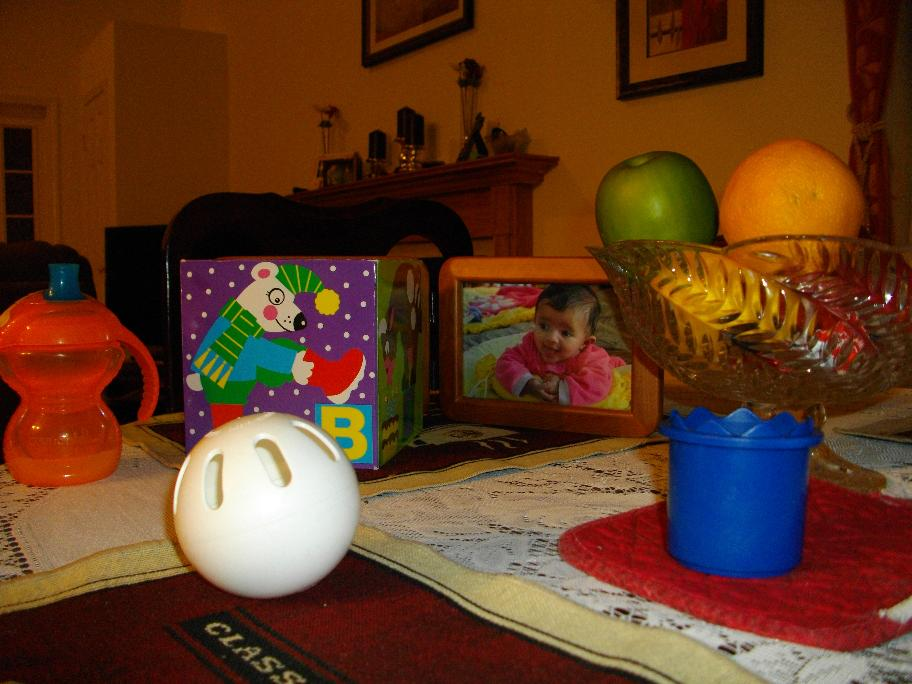

Image size: 912x684 pixels.


In [54]:
key_text = "世界你好啊"

##   /paris/paris
##  /lena/lena
##  /toys/toys
floder_path = "./images/toys/"
image_path = floder_path + "toys.jpg"

original_image = Image.open(image_path)
pic_width, pic_height = original_image.size

display(original_image)
print("Image size: {}x{} pixels.".format(pic_width, pic_height))

## 加密 图像 

图像 bytes_of_image after expand_to_128b 1871424
2073600
加密 所用时长: 0.3104851245880127


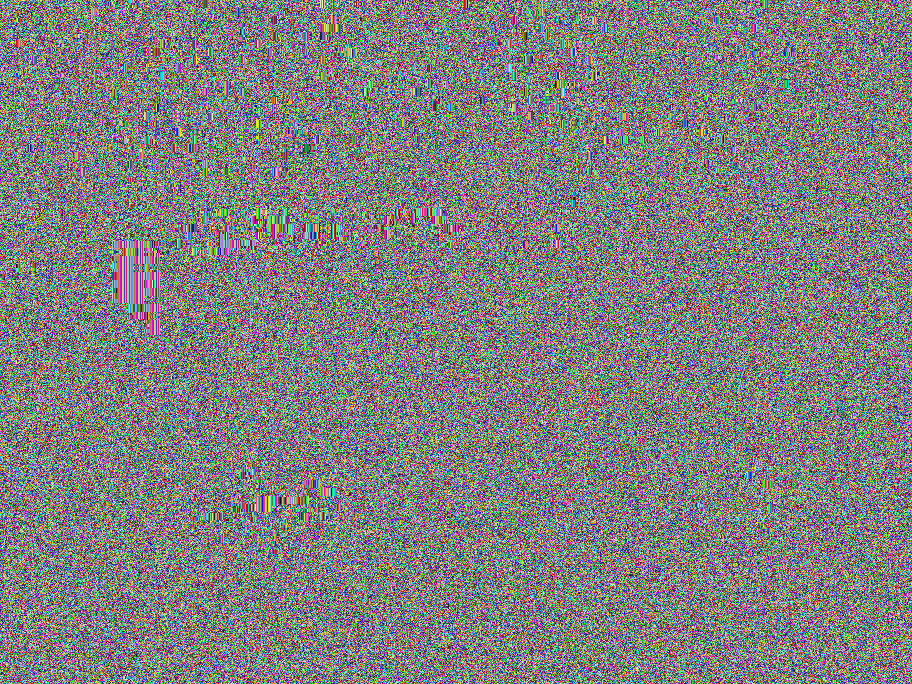

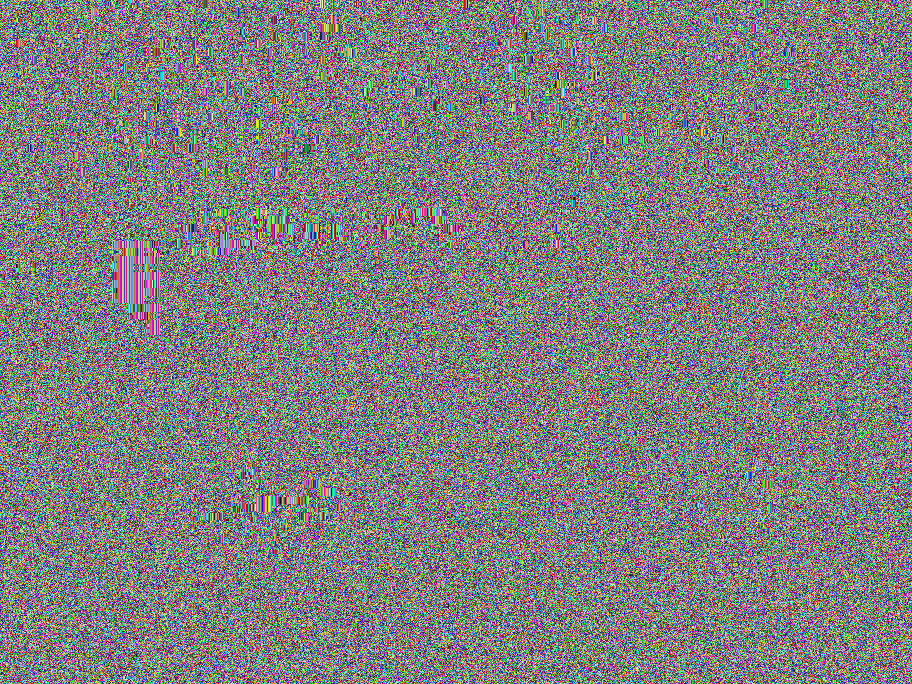

加密图


In [55]:
## 加密 图像 
encryption_image, encryption_image_bytes_arrray = image_AES_En_De(original_image, key_text, 0 )

encryption_image_bytes_arrray = bytes( encryption_image_bytes_arrray )
# encryption_image = Image.frombytes('L',(pic_width, pic_height ),encryption_image_bytes_arrray)
encryption_image2 = Image.frombytes('RGB',(pic_width, pic_height ),encryption_image_bytes_arrray)

display(encryption_image)
display(encryption_image2)
print("加密图")

## 解密 图像 

图像 bytes_of_image after expand_to_128b 1871424
2073600
解密 所用时长: 0.3054993152618408


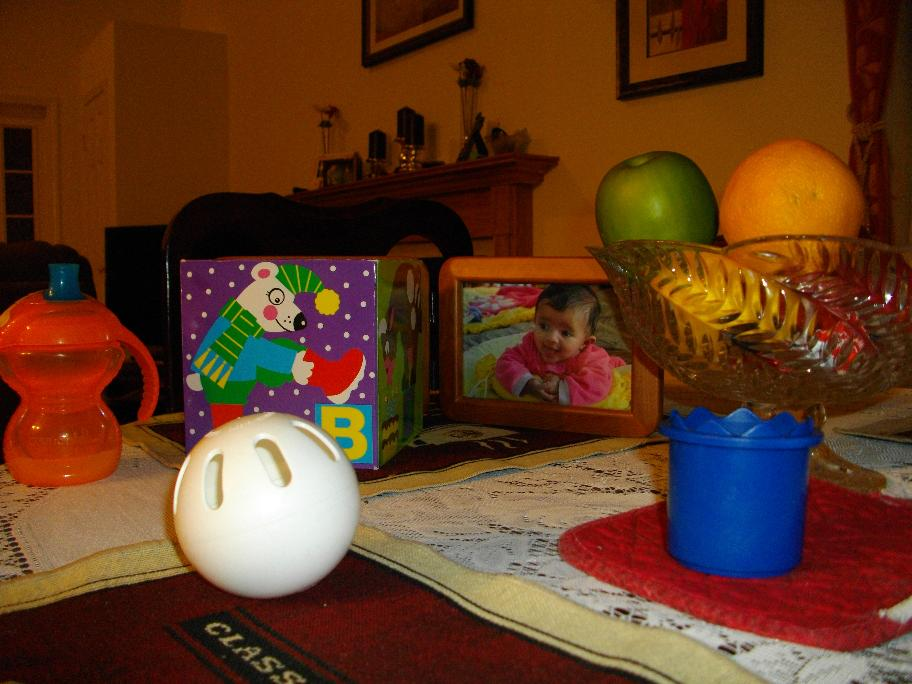

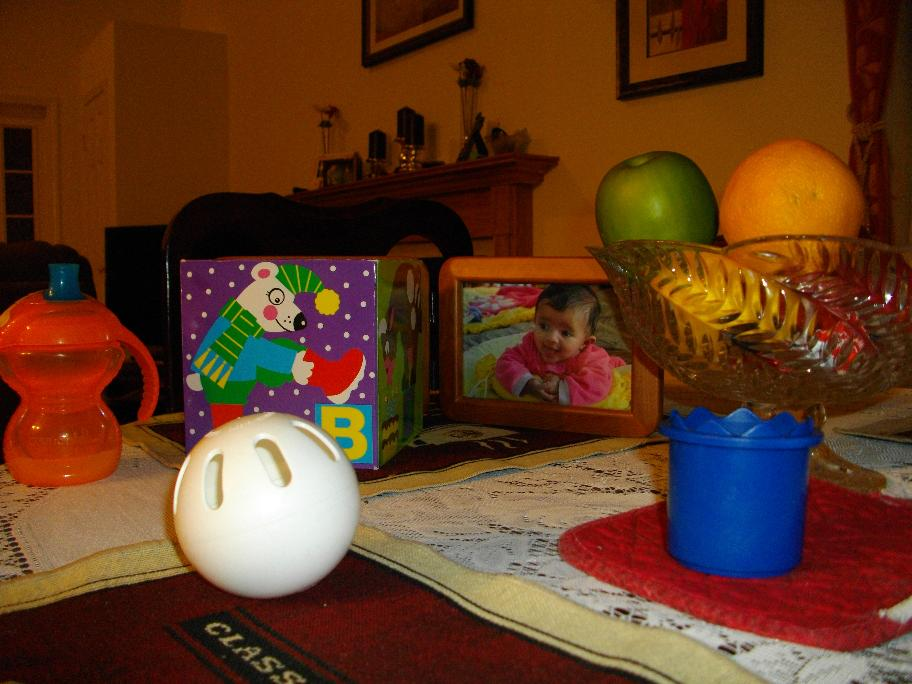

解密图


In [56]:
## 解密 图像 
decryption_image, decryption_image_bytes_arrray = image_AES_En_De(encryption_image, key_text, 1 )
decryption_image_bytes_arrray = bytes( decryption_image_bytes_arrray )

# encryption_image = Image.frombytes('L',(pic_width, pic_height ),decryption_image_bytes_arrray)
decryption_image2 = Image.frombytes('RGB',(pic_width, pic_height ),decryption_image_bytes_arrray)

display(decryption_image)
display(decryption_image2)
print("解密图")

In [57]:
original_image.save( floder_path + "original_image.jpg")
encryption_image.save( floder_path + "encryption_image.jpg")
decryption_image.save( floder_path + "decryption_image.jpg")